In [1]:
# Libraries
import numpy as np
import scipy.io as sio
import os
import pickle
# import re
import ieeg_funcs as ief
import dgFuncs as dg
from sklearn import preprocessing
# from scipy import stats
# from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import svm, linear_model
from sklearn.metrics import roc_auc_score
from sklearn.externals import joblib
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
Fs=10 # sampling rate of moving spectral energy window
refract_min=5
refract_tpt=np.round(Fs*refract_min*60)
print(refract_tpt)

3000


In [3]:
# 1096 files with clinican szrs in them
# 109600102_0072.head
# 109600102_0074.head
# 109600102_0095.head
# 109600102_0100.head
# 109600102_0119.head
# 109600102_0121.head
# 109600102_0123.head
# 109600102_0125.head
# 109600102_0147.head

In [4]:
sub=1096
# Get list of yhat files
#yhat_path='/Volumes/SgateOSExJnld/EU_TEMP/1096_all_labels'
yhat_path='/Users/davidgroppe/ONGOING/EU_YHAT/1096_genLogregSe_3/'
label_path='/Volumes/SgateOSExJnld/EU_TEMP/1096_all_labels/'

Fs=9.84615384615 # sampling rate of moving spectral energy window
refract_min=5
refract_tpt=np.round(Fs*refract_min*60)
total_hrs=0
n_false_pos=0
n_clin_szr=0
n_true_pos=0
stim_latency_sec=list()

# Loop over yhat files
for f in os.listdir(yhat_path):
    if f.endswith('.npz'):
        yhat_npz=np.load(os.path.join(yhat_path,f))
        n_wind=len(yhat_npz['max_yhat'])
        
        # Compute # of seconds in file
        file_dur_hr=n_wind/(Fs*3600)
        total_hrs+=file_dur_hr
        print('total_hrs=%f' % total_hrs)
        
        # Load clinician labels
        splt_f=f.split('_')
        label_fname=str(sub)+'_y_'+splt_f[0]+'_'+splt_f[1]+'.mat'
        label_f=os.path.join(label_path,label_fname)
        label_mat=sio.loadmat(label_f)
        
        # Compute stimulations with refractory periods
        stim=np.zeros(n_wind)
        stim_ids=list()
        last_stim=refract_tpt+1
        for wind_ct, yhat in enumerate(yhat_npz['max_yhat']):
            if yhat>.5 and last_stim>refract_tpt:
                stim[wind_ct]=1
                stim_ids.append(wind_ct)
                last_stim=0
            else:
                last_stim+=1

        # Compute false positives
        se_szr_class=np.squeeze(label_mat['se_szr_class'])
        nonszr_bool=se_szr_class==0
        print('false+ %d' % np.sum(stim[nonszr_bool]))
        n_false_pos+=np.sum(stim[nonszr_bool])
        
        # Compute sensitivity and latency to clinical szr onset (if any clinical szrs in the file)
        if 1 in se_szr_class:
            print('Clinical szr present')
            onset_id_list=list()
            offset_id_list=list()
            in_szr=False
            for tloop, y in enumerate(se_szr_class):
                if in_szr==False:
                    if y==1:
                        #entered new clinical szr
                        onset_id_list.append(tloop)
                        n_clin_szr+=1
                        in_szr=True
                else:
                    if y==0:
                        #exited clinical szr
                        offset_id_list.append(tloop-1)
                        in_szr=False
            if in_szr==True:
                # szr lasts until end of file
                offset_id_list.append(tloop-1)
            if len(onset_id_list)!=len(offset_id_list):
                print('Error: len(onset_id_list)!=len(offset_id_list) in %s!!!!' % f)
                break
            
            # Loop over clinical szrs (may be more than one in the clip)
            for temp_ct, onset_id in enumerate(onset_id_list):
                if sum(stim[onset_id:offset_id_list[temp_ct]]):
                    n_true_pos+=1
                # Find closest stimulation to clinician defined onset
                temp_id=np.argmin(np.abs(np.asarray(stim_ids)-onset_id))
                closest_id=stim_ids[temp_id]
                stim_latency_sec.append((closest_id-onset_id)/Fs)
        

fp_per_hour=n_false_pos/total_hrs
print('%f of false positives/hr' % fp_per_hour)
if n_clin_szr==0:
    print('No clinical szrs captured')
    sens=np.nan
else:
    sens=n_true_pos/n_clin_szr
    print('%d/%d clinical szrs, Sensitivity=%f' % (n_true_pos,n_clin_szr,sens))
    mn_latency_sec=np.mean(stim_latency_sec)
    sd_latency_sec=np.std(stim_latency_sec)
    print('Mean(SD) latency of stim relative to clinician onset: %.1f (%.1f) seconds' % (mn_latency_sec, sd_latency_sec))


total_hrs=0.966508
false+ 3
total_hrs=1.933016
false+ 1
total_hrs=2.899525
false+ 1
total_hrs=3.866033
false+ 3
Clinical szr present
2.069305 of false positives/hr
1/1 clinical szrs, Sensitivity=1.000000
Mean(SD) latency of stim relative to clinician onset: 38.7 (0.0) seconds


In [5]:
print(stim_ids)
print(onset_id_list)
print(stim_latency_sec)
print(29775-29384)

[9726, 23088, 29775, 33594]
[29394]
[38.69531250001511]
391


In [6]:
label_mat.keys()
n_false_pos

8.0

In [7]:
path_dict=ief.get_path_dict()
print(path_dict.keys())
path_dict['szr_ant_root']

dict_keys(['szr_ant_root', 'eu_meta', 'ftrs_root', 'eu_gen_ftrs', 'onset_csv', 'eu_root', 'pics', 'ieeg_root'])


'/Users/davidgroppe/PycharmProjects/SZR_ANT/'

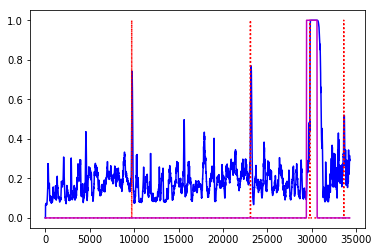

In [8]:
plt.figure(1)
plt.plot(yhat_npz['max_yhat'],'b-')
plt.plot(stim,'r:')
plt.plot(np.squeeze(label_mat['se_szr_class']),'m')

In [6]:
yhat_npz.keys()

['max_yhat', 'yhat_sec', 'yhat_soz_chans']

In [16]:
dlt=yhat_npz['yhat_sec'][0,1]-yhat_npz['yhat_sec'][0,0]
print(1/dlt)

9.84615384615
